In [2]:
# default_exp analysis

In [4]:
# export
import numpy as np

In [8]:
import matplotlib.pyplot as plt

# Common trajectory analysis tools

In [54]:
#export
def TAMSD(traj, t_lags):
    '''
    Calculates the time average mean squared displacement of a set of trajectories
    Inputs: - traj: trajectory to calculate TA-MSD
            - t_lags: time lags used for the TA-MSD
    Outputs: - TA-MSD
    '''
    tamsd = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags):        
        for p in range(len(traj)-t):
            tamsd[idx] += (traj[p]-traj[p+t])**2            
        tamsd[idx] /= len(traj)-t    
    return tamsd

def get_D(traj, t_lags = None):
    if not t_lags:
        N_t_lags = max(4, int(len(traj)*0.1))
        t_lags = np.arange(1,N_t_lags)
        
    tasmd = TAMSD(traj, t_lags)
    return np.polyfit(t_lags, tasmd, deg = 1)[0]/2

def get_exponent(traj, t_lags = None):
    if not t_lags:
        N_t_lags = max(4, int(len(traj)*0.1))
        t_lags = np.arange(1,N_t_lags)
        
    tasmd = TAMSD(traj, t_lags)
    return np.polyfit(np.log(t_lags), np.log(tasmd), deg = 1)[0]
    
    

# Convex hull

In [58]:
# export
from scipy.spatial import ConvexHull

def get_changepoints_convexhull(trajs, tau = 10):
    CPs = []
    for traj in trajs:
        traj = np.array(traj)
        
        Sd = np.zeros(traj.shape[0]-2*tau)
        for k in range(traj.shape[0]-2*tau):       
            Sd[k] = ConvexHull(traj[k:(k+2*tau)]).volume
            
        below_mean = Sd < Sd.mean()
        cp_traj = np.argwhere(below_mean[1:] != below_mean[:-1])+1
        CPs.append(cp_traj+tau)
        
    return CPs

In [60]:
get_changepoints_convexhull([traj])[0].flatten()

array([36, 64], dtype=int64)

Text(0, 0.5, '$S_d(n)$')

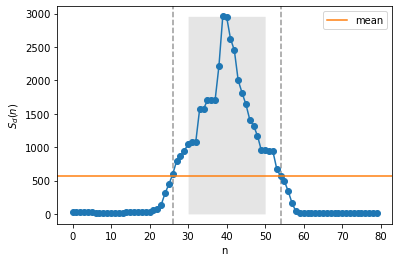

In [55]:
tau = 10
T = 100; on = 40; off = 60;

traj = np.random.randn(T, 2)
traj[on:off, :] = traj[on:off, :]*10
traj = traj.cumsum(0)

Sd = np.zeros(traj.shape[0]-2*tau)
for k in range(traj.shape[0]-2*tau):       
    Sd[k] = ConvexHull(traj[k:(k+2*tau)]).volume
    
below_mean = Sd < Sd.mean()
CPs = np.argwhere(below_mean[1:] != below_mean[:-1])+1

for cp in CPs:
    plt.axvline(cp, c = 'k', alpha = 0.4, ls = '--')
    
plt.plot(Sd, '-o')
plt.axhline(Sd.mean(), label = 'mean', c = 'C1',)
plt.legend()
plt.fill_betweenx(np.arange(Sd.max()), on-tau, off-tau, zorder = -1, alpha = 0.1, color = 'k', lw = 0)
plt.xlabel('n'); plt.ylabel(r'$S_d(n)$')
# plt.ylim(Sd.mean()-10, Sd.mean()+10)

# NBDEV Export

In [57]:
from nbdev.export import notebook2script
notebook2script()

Converted analysis_methods.ipynb.
Converted datasets_phenom.ipynb.
Converted datasets_theory.ipynb.
Converted models_phenom.ipynb.
Converted models_theory.ipynb.
Converted utils_challenge.ipynb.
Converted utils_trajectories.ipynb.
